In [1]:
# Set up logging
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    # filename = "logger.log",
)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, random, importlib, warnings
import torch, torch_geometric
import jupyter_black

import models_HMPNN_sum, models_HMPNN_ct, utils

jupyter_black.load()

# Ignoring UserWarnings
warnings.simplefilter("ignore", UserWarning)

# Setting random state seeds
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

2023-04-18 19:10:21 INFO NumExpr defaulting to 6 threads.


# Load Data

In [2]:
from torch_geometric.datasets import IMDB
import torch_geometric.transforms as T

transform = T.ToUndirected()  # Add reverse edge types.
data = IMDB(root="./data/IMDB/", transform=transform)[0]

# Making the classification problem binary by merging class 2 and 1
data["movie"].y[data["movie"].y == 2] = 1

# Add edge attributes to all edges. The model expects edge attributes, and will produce error if it does not exist
for edge_type in data.edge_types:
    data[edge_type].edge_attr = torch.ones(
        [data[edge_type].edge_index.shape[1], 1], dtype=torch.float32
    )

# Reducing the number of node features by removing those that are most frequently equal to zero
feature_mask = (data["movie"].x != 0).sum(dim=0) > 150
data["movie"].x = data["movie"].x[:, feature_mask]

feature_mask = (data["director"].x != 0).sum(dim=0) > 150
data["director"].x = data["director"].x[:, feature_mask]

feature_mask = (data["actor"].x != 0).sum(dim=0) > 400
data["actor"].x = data["actor"].x[:, feature_mask]

# Casting the reponse variable to float and reshaping it to match the exepcted dimension
data["movie"].y = data["movie"].y.reshape([len(data["movie"].y), 1]).to(torch.float32)

# Creating (new) train/validation/test splits (The original one has a very large test-set)
importlib.reload(utils)
(
    data["movie"].train_mask,
    data["movie"].val_mask,
    data["movie"].test_mask,
) = utils.train_val_test_split(0.2, 0.2, data["movie"].y[:, 0])

# Training HMPNN_sum Model

2023-04-18 19:10:23 INFO Epoch #0. Validation loss: 13.5139


5340


2023-04-18 19:10:28 INFO Epoch #50. Validation loss: 0.8219
2023-04-18 19:10:33 INFO Epoch #100. Validation loss: 0.6357
2023-04-18 19:10:38 INFO Epoch #150. Validation loss: 0.6157
2023-04-18 19:10:44 INFO Epoch #200. Validation loss: 0.6042
2023-04-18 19:10:49 INFO Epoch #250. Validation loss: 0.5963
2023-04-18 19:10:55 INFO Epoch #300. Validation loss: 0.5897
2023-04-18 19:11:01 INFO Epoch #350. Validation loss: 0.5833
2023-04-18 19:11:07 INFO Epoch #400. Validation loss: 0.5794
2023-04-18 19:11:13 INFO Epoch #450. Validation loss: 0.5762
2023-04-18 19:11:19 INFO Epoch #500. Validation loss: 0.5732
2023-04-18 19:11:25 INFO Epoch #550. Validation loss: 0.5697
2023-04-18 19:11:30 INFO Epoch #600. Validation loss: 0.5649
2023-04-18 19:11:36 INFO Epoch #650. Validation loss: 0.5622
2023-04-18 19:11:42 INFO Epoch #700. Validation loss: 0.5603
2023-04-18 19:11:48 INFO Epoch #750. Validation loss: 0.5586
2023-04-18 19:11:54 INFO Epoch #800. Validation loss: 0.5534
2023-04-18 19:12:00 INFO 

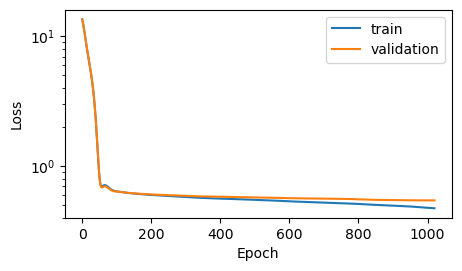

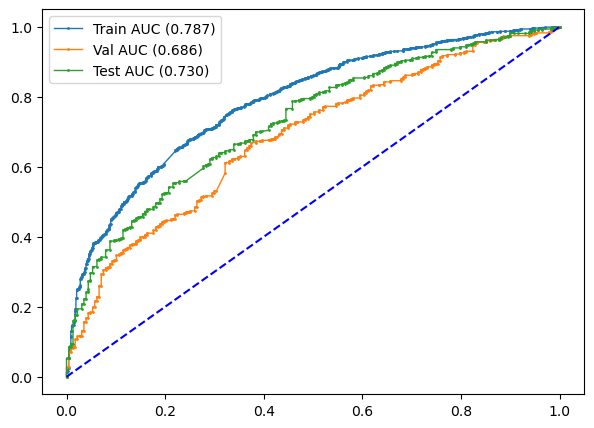

In [3]:
node_type_to_classify = "movie"
learning_rate = 1e-3
weight_decay = 1e-5
min_epochs = 1000
max_epochs = 10_000
print_learning_progress_freq = 50

# Initialize model
model = models_HMPNN_sum.HMPNN_sum_3Layer(data, node_type_to_classify)
print(utils.get_num_params_of_model(model))

# Train Model
model, train_hist = utils.train_model(
    model,
    data,
    node_type_to_classify,
    learning_rate,
    weight_decay,
    min_epochs,
    max_epochs,
    print_learning_progress_freq,
)

# Plot Results
utils.plot_training_hist(train_hist)

with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

utils.plot_roc_curves(data, pred, node_type_to_classify)

# Training models_HMPNN_ct Model

2023-04-18 19:12:20 INFO Epoch #0. Validation loss: 0.6397


5291


2023-04-18 19:12:26 INFO Epoch #50. Validation loss: 0.5780
2023-04-18 19:12:31 INFO Epoch #100. Validation loss: 0.5773
2023-04-18 19:12:37 INFO Epoch #150. Validation loss: 0.5758
2023-04-18 19:12:42 INFO Epoch #200. Validation loss: 0.5701
2023-04-18 19:12:48 INFO Epoch #250. Validation loss: 0.5417
2023-04-18 19:12:53 INFO Epoch #300. Validation loss: 0.5306
2023-04-18 19:12:59 INFO Epoch #350. Validation loss: 0.5250
2023-04-18 19:13:04 INFO Epoch #400. Validation loss: 0.5196
2023-04-18 19:13:10 INFO Epoch #450. Validation loss: 0.5173
2023-04-18 19:13:15 INFO Epoch #500. Validation loss: 0.5179
2023-04-18 19:13:21 INFO Epoch #550. Validation loss: 0.5194
2023-04-18 19:13:26 INFO Epoch #600. Validation loss: 0.5206
2023-04-18 19:13:32 INFO Epoch #650. Validation loss: 0.5219
2023-04-18 19:13:37 INFO Epoch #700. Validation loss: 0.5259
2023-04-18 19:13:43 INFO Epoch #750. Validation loss: 0.5291
2023-04-18 19:13:48 INFO Epoch #800. Validation loss: 0.5305
2023-04-18 19:13:54 INFO 

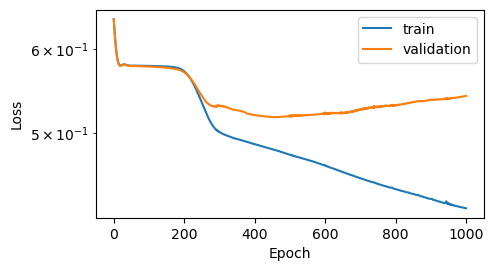

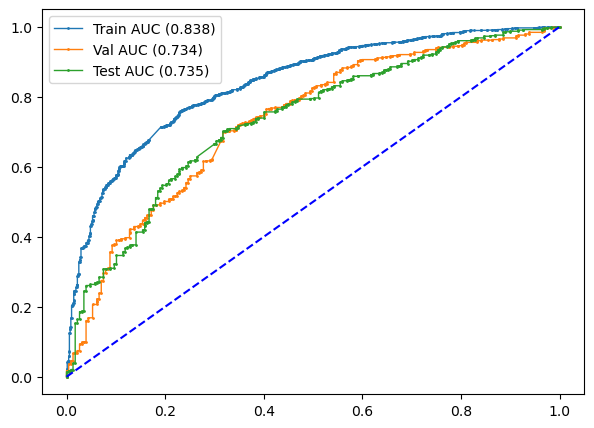

In [4]:
node_type_to_classify = "movie"
learning_rate = 1e-3
weight_decay = 1e-7
min_epochs = 1_000
max_epochs = 10_000
print_learning_progress_freq = 50
# Initialize model
model = models_HMPNN_ct.HMPNN_ct_3Layer(data, node_type_to_classify)
print(utils.get_num_params_of_model(model))

# Train Model
model, train_hist = utils.train_model(
    model,
    data,
    node_type_to_classify,
    learning_rate,
    weight_decay,
    min_epochs,
    max_epochs,
    print_learning_progress_freq,
)

# Plot Results
utils.plot_training_hist(train_hist)

with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

utils.plot_roc_curves(data, pred, node_type_to_classify)